# CPSC 330 Lecture 14

### Lecture plan

- 👋
- **Turn on recording**
- Announcements
- Vectors, distances, neighbours (20 min)
- Cosine similarity (10 min)
- Break (5 min)
- Ratings data (5 min)
- Sparse matrices (15 min)
- KNN for product similarity (5 min)
- Distances with sparse data (15 min)
- T/F questions (10 min)

In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.sparse import csr_matrix, csc_matrix

import seaborn as sns

from sklearn.neighbors import NearestNeighbors

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline, make_pipeline

In [2]:
from IPython.core.display import display, HTML

In [3]:
plt.rcParams['font.size'] = 16

## Announcements

(same as Tuesday)

- Midterm grading in progress
- hw6 will be posted at the end of this week or weekend hopefully
- Lecture 12 screencast posted, please watch before hw6
- Final exam format posted: https://piazza.com/class/kb2e6nwu3uj23?cid=429

## Vectors, distances, neighbours (20 min)

#### Distances between points

- First, we need to talk a bit about vectors and distances.
- Let's return to to the cities dataset from the beginning of the course.

In [52]:
cities_df = pd.read_csv('data/cities_USA.csv', index_col=0)

In [53]:
blue = cities_df.query('vote == "blue"')
red  = cities_df.query('vote == "red"')

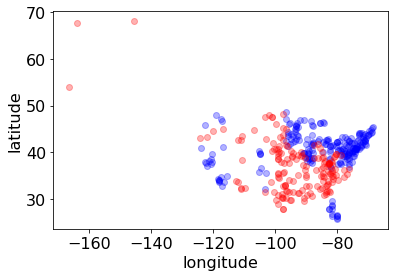

In [54]:
plt.scatter(blue["lon"], blue["lat"], color="blue", alpha=0.3);
plt.scatter(red["lon"], red["lat"], color="red", alpha=0.3);
plt.ylabel("latitude");
plt.xlabel("longitude");

Let's take 2 points:

In [55]:
two_cities = cities_df.sample(2, random_state=30).drop(columns=['vote'])

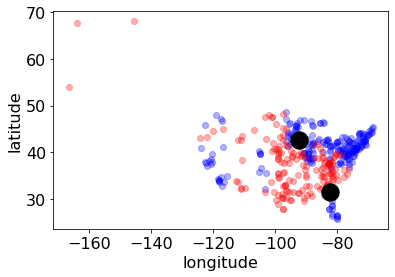

In [56]:
plt.scatter(blue["lon"], blue["lat"], color="blue", alpha=0.3);
plt.scatter(red["lon"], red["lat"], color="red", alpha=0.3);
plt.scatter(two_cities["lon"], two_cities["lat"], color="black", s=300);
plt.ylabel("latitude");
plt.xlabel("longitude");

- For the cities at the two big cicles, what is the _distance_ between them? (Ignoring the curvature of the Earth!)

In [57]:
two_cities

,lon,lat
36,-82.249594,31.402780
317,-92.341701,42.673137


Subtract the two cities:

In [58]:
two_cities.iloc[1] - two_cities.iloc[0]

lon   -10.092107
lat    11.270357
dtype: float64

Square the differences:

In [59]:
(two_cities.iloc[1] - two_cities.iloc[0])**2

lon    101.850624
lat    127.020947
dtype: float64

Sum them up:

In [60]:
np.sum((two_cities.iloc[1] - two_cities.iloc[0])**2)

228.8715706068982

Take the square root:

In [61]:
np.sqrt(np.sum((two_cities.iloc[1] - two_cities.iloc[0])**2))

15.128501928707223

The above is called the Euclidean distance. 

In [62]:
sklearn.metrics.pairwise.euclidean_distances(two_cities)

array([[ 0.        , 15.12850193],
       [15.12850193,  0.        ]])

#### Finding the nearest neighbour

- We can find the closest cities to City 0.
- Let's start with a subset of 4 cities.

In [80]:
dists = sklearn.metrics.pairwise.euclidean_distances(cities_df[["lat", "lon"]].iloc[:4])
dists

array([[0.        , 0.25726537, 0.54650006, 0.60587695],
       [0.25726537, 0.        , 0.31414736, 0.34945028],
       [0.54650006, 0.31414736, 0.        , 0.16437124],
       [0.60587695, 0.34945028, 0.16437124, 0.        ]])

In [81]:
dists.shape

(4, 4)

These are the distances between City 0 and the other cities:

In [83]:
dists[0]

array([0.        , 0.25726537, 0.54650006, 0.60587695])

We can find the smallest with `np.argmin`:

In [84]:
np.argmin(dists[0])

0

Whoops, that just says city 0 is closest to city 0...

In [85]:
np.fill_diagonal(dists, np.inf)
dists

array([[       inf, 0.25726537, 0.54650006, 0.60587695],
       [0.25726537,        inf, 0.31414736, 0.34945028],
       [0.54650006, 0.31414736,        inf, 0.16437124],
       [0.60587695, 0.34945028, 0.16437124,        inf]])

In [86]:
np.argmin(dists[0])

1

Ok, so the closest city to City 0 is City 1. 

We can do this again with all the cities included, to get the closest overall.

#### Finding the distances to a query point

We can also find the distances to a new "test" or "query" city:

In [88]:
dists = sklearn.metrics.pairwise.euclidean_distances(cities_df[["lat", "lon"]], [[0, 0]])
dists[:10]

array([[ 84.17901524],
       [ 84.30562848],
       [ 84.28113295],
       [ 84.4453635 ],
       [ 85.92913939],
       [ 84.32289429],
       [ 86.10623378],
       [ 86.36094249],
       [ 87.25286283],
       [101.30925538]])

In [89]:
np.argmin(dists)

357

Apparently City 357 is closest to the point $(0,0)$.

#### Using sklearn `NearestNeighbours`

In [90]:
from sklearn.neighbors import NearestNeighbors

In [91]:
nn = NearestNeighbors(n_neighbors=1)
nn.fit(cities_df[['lon', 'lat']]);

In [92]:
nn.kneighbors([[0,0]])

(array([[81.81189213]]), array([[357]]))

There is is again: City 357, with a distance of around 82.

#### Beyond 2 dimensions

- All this matches our intuition of "distance" in the real world.
- And we could also extend it to points in 3D space.
- In fact, we can extend it to arrays ("vectors") of any length.
- Here is the housing data again (I know I shouldn't be copy/pasting so many times...)

In [93]:
df = pd.read_csv("data/housing.csv", index_col=0)

df_train, df_test = train_test_split(df, random_state=123)

X_train = df_train.drop(columns=['SalePrice'])
y_train = df_train['SalePrice']

X_test = df_test.drop(columns=['SalePrice'])
y_test = df_test['SalePrice']

In [94]:
numeric_features     = ['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 
                        'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 
                        'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 
                        'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 
                        'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 
                        'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 
                        'ScreenPorch', 'PoolArea', 'MiscVal', 'YrSold']
ordinal_features_reg = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 
                        'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC']
ordinal_features_oth = ['BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 
                        'Functional',  'Fence']
categorical_features = list(set(X_train.columns) - set(numeric_features) - set(ordinal_features_reg))

ordering = ['Po', 'Fa', 'TA', 'Gd', 'Ex']

In [100]:
numeric_preprocessing = make_pipeline(SimpleImputer(strategy='median'), 
                                      StandardScaler())
ordinal_preprocessing = make_pipeline(SimpleImputer(strategy='most_frequent'), 
                                      OrdinalEncoder(categories=[ordering]*len(ordinal_features_reg)))
categorical_preprocessing = make_pipeline(SimpleImputer(strategy='constant', fill_value="?"),
                                          OneHotEncoder(handle_unknown='ignore', sparse=False))

In [101]:
preprocessing = ColumnTransformer([
    ('numeric', numeric_preprocessing, numeric_features),
    ('ordinal', ordinal_preprocessing, ordinal_features_reg),
    ('categorical', categorical_preprocessing, categorical_features)
])

In [102]:
preprocessing.fit(X_train);

In [103]:
ohe_columns = list(preprocessing.named_transformers_['categorical'].named_steps['onehotencoder'].get_feature_names(categorical_features))
new_columns = numeric_features + ordinal_features_reg + ohe_columns

In [110]:
X_train_enc = pd.DataFrame(preprocessing.transform(X_train), index=X_train.index, columns=new_columns)
X_test_enc = pd.DataFrame(preprocessing.transform(X_test), index=X_test.index, columns=new_columns)

X_train_enc.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,KitchenAbvGr_1,KitchenAbvGr_2
Id,,,,,,,,,,,,,,,,,,,,,
1447,-0.046315,1.654400,-0.775646,1.255836,-0.282035,-1.105566,0.491436,0.327430,-0.28498,0.064219,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1124,-0.888437,-0.093394,-0.775646,3.019968,-0.773017,1.117128,-0.569906,-0.942714,-0.28498,0.297501,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
187,-0.046315,-0.036795,0.647021,-0.508295,0.634466,0.295697,-0.569906,0.365985,-0.28498,0.023451,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1021,-0.420591,-0.342035,-1.486980,-0.508295,1.125448,0.972169,-0.569906,1.250588,-0.28498,-1.038776,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
68,0.140824,0.038184,0.647021,-0.508295,1.059984,0.875531,0.367894,1.227027,-0.28498,-0.286837,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


- Each house is now a length-292 vectors (292 columns).
- We could compute the distance between them.

In [111]:
dists = sklearn.metrics.pairwise.euclidean_distances(X_train_enc[:3])
dists

array([[ 0.        ,  9.38944568,  6.92285556],
       [ 9.38944568,  0.        , 10.42007981],
       [ 6.92285556, 10.42007981,  0.        ]])

That is, the distance between house 1 and house 2 is:

In [112]:
dists[1,2]

10.420079813360319

Find the most similar training house to test house 1:

In [113]:
nn = NearestNeighbors(n_neighbors=1)
nn.fit(X_train_enc);

In [114]:
nn.kneighbors(X_test_enc.iloc[[1]])

(array([[6.48464496]]), array([[135]]))

You can also ask `NearestNeighbors` to return, say, the 5 nearest neighbours:

Find the 5 most similar training houses to test house 1:

In [117]:
nn = NearestNeighbors(n_neighbors=5)
nn.fit(X_train_enc);

In [118]:
nn.kneighbors(X_test_enc.iloc[1])

ValueError: Expected 2D array, got 1D array instead:
array=[-0.42059121 -0.07303068 -1.4869801  -3.1544927  -2.31142832 -1.68539965
 -0.56990559 -0.94271399 -0.28497976  1.19665728  0.09078342 -0.1712858
  0.75226225 -0.12494295  0.4713169   1.12185796 -0.23230498  0.78133697
 -0.76298931  0.89254471 -0.95298286 -2.38964366  1.66822305  1.47422693
 -0.75391691 -0.68595031  1.13785531 -0.10896508 -0.26487686 -0.07333341
 -0.10879978 -1.39396214  2.          2.          2.          1.
  1.          2.          3.          1.          1.          4.
  1.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          1.
  0.          0.          0.          0.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.          0.          1.          1.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          1.
  0.          0.          0.          0.          0.          1.
  0.          0.          0.          0.          0.          0.
  1.          0.          0.          0.          0.          0.
  1.          0.          0.          0.          0.          0.
  0.          0.          1.          0.          0.          1.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.          1.          1.
  0.          0.          1.          0.          0.          0.
  0.          0.          1.          0.          0.          1.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          1.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.          1.          0.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          1.          0.          0.          0.
  1.          0.          0.          0.          1.          0.
  0.          0.          0.          1.          0.          1.
  0.          0.          0.          0.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.          0.          1.          0.          1.
  0.          0.          0.          0.          0.          1.
  0.          0.          1.          0.          0.          0.
  0.          0.          0.          1.        ].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

- You'll see this error a lot. 
- We need to pass in something 2D:

In [119]:
X_test_enc.iloc[1].shape

(292,)

In [120]:
X_test_enc.iloc[[1]].shape

(1, 292)

In [121]:
nn.kneighbors(X_test_enc.iloc[[1]])

(array([[6.48464496, 6.9013241 , 7.25672098, 7.79379333, 7.80278473]]),
 array([[135, 517, 861, 834, 535]]))

## Cosine similarity (10 min)

## Break (5 min)

REMINDER TO RESUME RECORDING

## Amazon product dataset

We'll be looking at the [Amazon product data set](http://jmcauley.ucsd.edu/data/amazon/). The author of the data set has asked for the following citations:

> Ups and downs: Modeling the visual evolution of fashion trends with one-class collaborative filtering.
> R. He, J. McAuley.
> WWW, 2016.
> 
> Image-based recommendations on styles and substitutes.
> J. McAuley, C. Targett, J. Shi, A. van den Hengel.
> SIGIR, 2015.

We will focus on the Patio, Lawn, and Garden section. Please download the [ratings](http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/ratings_Patio_Lawn_and_Garden.csv) and place them in the data directory with their default filenames. The code below should load the data:

In [44]:
ratings = pd.read_csv("data/ratings_Patio_Lawn_and_Garden.csv", names=("user","item","rating","timestamp"))
ratings.head()

,user,item,rating,timestamp
0,A2VNYWOPJ13AFP,0981850006,5.0,1259798400
1,A20DWVV8HML3AW,0981850006,5.0,1371081600
2,A3RVP3YBYYOPRH,0981850006,5.0,1257984000
3,A28XY55TP3Q90O,0981850006,5.0,1314144000
4,A3VZW1BGUQO0V3,0981850006,5.0,1308268800


- Our goal will be to find similar items to recommend given an item. 
- We will do this by recommending items that got similar ratings from the same users.
- Another approach would be to look at features of the items like name, price, etc.
- The methods we'll talk about today would apply equally well there.

Let's compute some summary statistics:

In [46]:
len(ratings)

993490

In [47]:
np.mean(ratings["rating"])

4.006400668350965

Histogram of number of ratings per item:

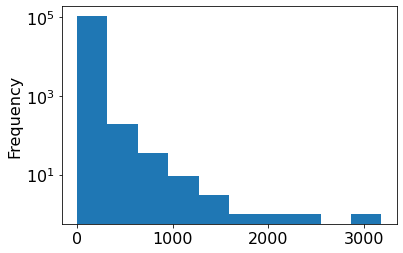

In [50]:
ratings['item'].value_counts().plot.hist(log=True);

Histogram of number of ratings per user:

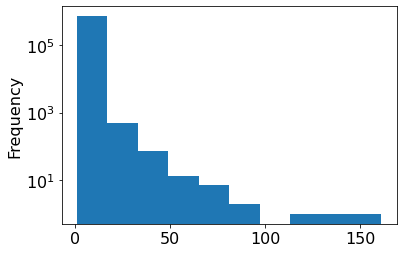

In [51]:
ratings['user'].value_counts().plot.hist(log=True);

In [45]:
def get_stats(ratings, item_key="item", user_key="user"):
    print("Number of ratings:", len(ratings))
    print("The average rating:", np.mean(ratings["rating"]))

    n_items = len(set(ratings[item_key]))
    n_users = len(set(ratings[user_key]))
    print("Number of users:", n_users)
    print("Number of items:", n_items)
    print("Fraction nonzero:", len(ratings)/(n_items*n_users))
    print("Size of full matrix (GB):", (n_items*n_users)*8/1e9)

    return n_items, n_users

n_items, n_users = get_stats(ratings)

Number of ratings: 993490
The average rating: 4.006400668350965
Number of users: 714791
Number of items: 105984
Fraction nonzero: 1.3114269915944552e-05
Size of full matrix (GB): 606.051274752


- We'd like to reshape things into an array of number of users by number of items.
- But, as shown above, this would be about 600 GB! That is way too big.
- This is a prime example of where sparse matrices would be helpful. 
- We only have about 1 million ratings, which would be 8 MB or so. Much more manageable. 

In [7]:
def create_X(ratings, n_items, n_users, user_key="user", item_key="item"):
    """
    Creates a sparse matrix using scipy.csr_matrix and mappers to relate indexes to items' id.
    
    Parameters:
    -----------
    ratings: the ratings to be stored in the matrix;
    n_items: the number of items
    n_users: the number of users
    user_key: the column in the pandas dataframe that contains the users id
    item_key: the column in the pandas dataframe that contains the items id
    
    Returns: (X, user_mapper, item_mapper, user_inverse_mapper, item_inverse_mapper, user_ind, item_ind)
    --------
    X: the sparse matrix containing the ratings
    user_mapper: stores the indexes of the users - the user_id is the key
    item_mapper: stores the indexes of the items - the item_id is the key
    user_inverse_mapper: stores the user id - the user index is the key
    item_inverse_mapper: stores the item id - the item index is the key
    user_ind: indexes of the users
    item_ind: indexes of the items
    """
    
    user_mapper = dict(zip(np.unique(ratings[user_key]), list(range(n_users))))
    item_mapper = dict(zip(np.unique(ratings[item_key]), list(range(n_items))))

    user_inverse_mapper = dict(zip(list(range(n_users)), np.unique(ratings[user_key])))
    item_inverse_mapper = dict(zip(list(range(n_items)), np.unique(ratings[item_key])))

    user_ind = [user_mapper[i] for i in ratings[user_key]]
    item_ind = [item_mapper[i] for i in ratings[item_key]]

    X = csc_matrix((ratings["rating"], (item_ind, user_ind)), shape=(n_items, n_users)).T
    
    return X, user_mapper, item_mapper, user_inverse_mapper, item_inverse_mapper, user_ind, item_ind

In [8]:
X_user_item, user_mapper, item_mapper, user_inverse_mapper, item_inverse_mapper, user_ind, item_ind = create_X(ratings, n_items, n_users)

In [9]:
type(X_user_item)

scipy.sparse.csr.csr_matrix

In [10]:
X_user_item.shape

(714791, 105984)

In [11]:
X_user_item.nnz

993490

#### EDA

Let's find the following items the item with the most reviews:

In [12]:
idx_most_reviews = np.argmax(np.sum(X_user_item>0, axis=0))
idx_most_reviews

10959

In [13]:
np.max(np.sum(X_user_item>0, axis=0))

3180

Then we can look up the Amazon id:

In [14]:
item_inverse_mapper[idx_most_reviews]

'B000HCLLMM'

And get the URL:

In [15]:
url_amazon = "https://www.amazon.com/dp/%s"
def disp_url(item_id):
    url = url_amazon % item_id
    display(HTML('<a href="%s">%s</a>' % (url,url)))

disp_url(item_inverse_mapper[idx_most_reviews])

We can do the same for the lowest average stars:

In [16]:
idx_lowest_avg = np.argmin(np.sum(X_user_item, axis=0)/np.sum(X_user_item>0,axis=0))

disp_url(item_inverse_mapper[idx_lowest_avg])

Next, we make some histograms:

<ipython-input-17-05b22dbbbf74>:3: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.yscale('log', nonposy='clip')


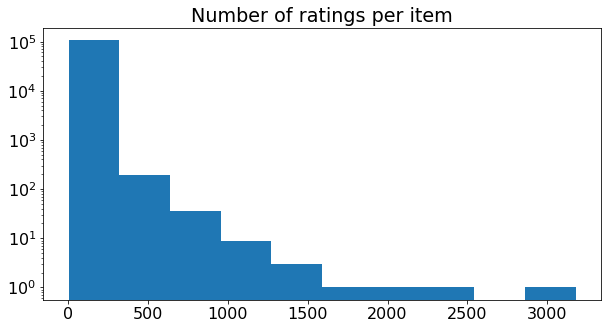

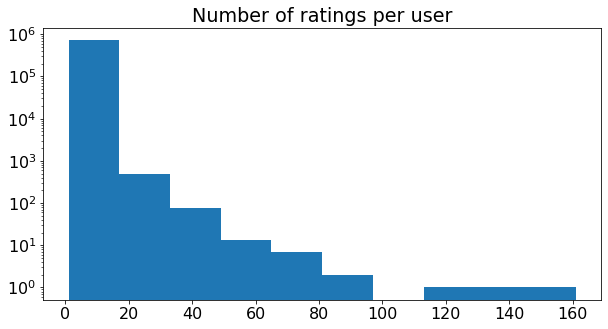

In [17]:
def make_num_ratings_hist(X, title=None):
    plt.figure(figsize=(10,5))
    plt.yscale('log', nonposy='clip')
    plt.hist(np.sum(X>0, axis=1))
    plt.title(title)
    plt.show()
    
make_num_ratings_hist(X_user_item.T, "Number of ratings per item")
make_num_ratings_hist(X_user_item, "Number of ratings per user")

- Note the log scales on the vertical axes. 
- We can see some "super items" and "super reviewers".

In [18]:
np.min(np.sum(X_user_item>0, axis=1))

1

In [19]:
np.min(np.sum(X_user_item>0, axis=0))

1

#### Our goal

- Our goal for today is to recommend similar items given a query item.
- This is like the "Customers also shopped for" section on Amazon.

## Sparse matrices in Python (10 min)

We had this code earlier:

In [21]:
X_train_counts[0].toarray()

array([[0, 0, 0, ..., 0, 0, 0]])

Why did we need `.toarray()`?

In [26]:
type(X_train_counts)

scipy.sparse.csr.csr_matrix

This is a **sparse matrix**. Why? Look at the shape:

In [22]:
X_train_counts.shape

(37500, 91308)

How many elements total?

In [28]:
np.prod(X_train_counts.shape)

3424050000

A lot! How many are nonzero though?

In [29]:
X_train_counts.nnz

5114043

In [30]:
frac_nz = X_train_counts.nnz / np.prod(X_train_counts.shape)
frac_nz

0.0014935655145222762

- This happens because most words do not appear in a given document. 
- We get massive computational savings if we **only store the nonzero elements**. 
- There is a bit of overhead, because we also need to **store the locations**:
  - e.g. "location (5,192): 3".
  - However, if the fraction of nonzero is small, this is a huge win.

Here are the nonzero elements in the first review:

In [31]:
print(X_train_counts[0])

  (0, 1893)	1
  (0, 1894)	1
  (0, 4036)	2
  (0, 4378)	1
  (0, 5338)	1
  (0, 5509)	1
  (0, 5868)	2
  (0, 6013)	1
  (0, 7736)	2
  (0, 7843)	1
  (0, 8109)	1
  (0, 8806)	1
  (0, 10625)	1
  (0, 10826)	6
  (0, 12242)	2
  (0, 13705)	1
  (0, 14076)	1
  (0, 15561)	1
  (0, 18502)	1
  (0, 19264)	3
  (0, 19379)	1
  (0, 20503)	1
  (0, 20762)	1
  (0, 21067)	1
  (0, 22422)	2
  :	:
  (0, 63802)	2
  (0, 66090)	1
  (0, 66751)	1
  (0, 66890)	1
  (0, 67724)	1
  (0, 69096)	1
  (0, 70346)	1
  (0, 73319)	1
  (0, 74862)	1
  (0, 76703)	1
  (0, 80828)	1
  (0, 80846)	12
  (0, 81118)	4
  (0, 81556)	1
  (0, 81794)	2
  (0, 83065)	1
  (0, 83651)	1
  (0, 86703)	1
  (0, 86710)	1
  (0, 87889)	3
  (0, 88008)	7
  (0, 88172)	3
  (0, 88502)	2
  (0, 88885)	1
  (0, 89196)	1


- BTW, have you noticed that with `OneHotEncoder` we've been setting `sparse=False`. 
- This is to get it to return a regular numpy array instead of a sparse array, so we didn't have to deal with these.
- If there are a huge number of categories, it may be beneficial to keep them as sparse.
- For smaller number of categories, it doesn't matter much.

#### Working with scipy.sparse matrices

- We won't go into implementation details here, but there are some "gotchas" with `scipy.sparse`.
- For example, with a regular numpy array, `x[i,j]` and `x[i][j]` are equivalent:

In [24]:
x = np.random.rand(10, 10)

In [33]:
x[1, 2]

0.19861089003333154

In [34]:
x[1][2]

0.19861089003333154

In [35]:
(x[1])[2]

0.19861089003333154

This is because `x[1]` returns the first row, and then the `[2]` indexes into that row:

In [36]:
x[1]

array([0.65399277, 0.84521827, 0.19861089, 0.00167515, 0.64181605,
       0.25209052, 0.01963685, 0.51772779, 0.19828813, 0.44265865])

In [37]:
row_1 = x[1]
row_1[2]

0.19861089003333154

However, with `scipy.sparse` matrices, things are a bit different:

In [25]:
x_sparse = scipy.sparse.csr_matrix(x)

In [26]:
x_sparse[1, 2]

0.18289061542864404

In [27]:
x_sparse[1][2]

IndexError: row index (2) out of range

Why?

In [28]:
row_1_sparse = x_sparse[1]

In [42]:
row_1_sparse.shape

(1, 10)

- The sparse matrix returns a different shape, leaving in the first dimension.
- This can be annoying and is something to watch out for.
- In general, I suggest using the `x[1,2]` notation when possible because chaining the `[]` can be problematic in several places (e.g., also pandas).
- However, this is only for numpy, not, say, a list of lists:

In [43]:
lst = [[1, 2, 3], [4, 5, 6], [7, 9]]
lst

[[1, 2, 3], [4, 5, 6], [7, 9]]

In [44]:
lst[0][1]

2

In [45]:
lst[0, 1]

TypeError: list indices must be integers or slices, not tuple

#### sparse matrix operations

Let's try to find the highest word count. But first, review the `axis` keyword:

In [46]:
x = np.random.randint(10, size=(4,5))
x

array([[9, 4, 8, 0, 0],
       [6, 2, 5, 9, 7],
       [1, 2, 3, 4, 0],
       [0, 1, 6, 3, 6]])

In [47]:
np.sum(x)

76

In [48]:
np.sum(x, axis=0)

array([16,  9, 22, 16, 13])

In [49]:
np.sum(x, axis=1)

array([21, 29, 10, 16])

Back to our word counts:

In [50]:
X_train_counts.max()

198

The max for each document:

In [51]:
X_train_counts.max(axis=1)

<37500x1 sparse matrix of type '<class 'numpy.int64'>'
	with 37500 stored elements in COOrdinate format>

The document with the highest word count:

In [52]:
np.argmax(X_train_counts.max(axis=1))

26017

- Regular numpy functions work on sparse matrices, although they might be fast/slow depending. 
- You definitely do not want to iterate with loops - make sure you use builtin functions. 
- There are some details here, in that a sparse matrix max be stored row-by-row or column-by-column, and this affects speed.
  - This is beyond the scope of the course, but something to look into if your code is too slow.

## KNN for product similarity (5 min)

Let's find find the 5 items most similar to [GRILL HOGS 18" GRILL CLEANING BRUSH](https://www.amazon.com/dp/B00CFM0P7Y). 

In [ ]:
grill_brush = "B00CFM0P7Y"
grill_brush_ind = item_mapper[grill_brush]
grill_brush_vec = X_user_item[grill_brush_ind]

Here is the strategy:

- We have a matrix `X_user_item` of users x items.
- Let's transpose it:

In [ ]:
X_item_user = X_user_item.T

In [ ]:
X_user_item.shape

In [ ]:
X_item_user.shape

In [ ]:
# type(X_item_user)

In [ ]:
# type(X_user_item)

- This is now items x users.
- Each item is an observation, and we treat the users as features/columns.
- Assumption: **a similar item is an item that receives similar reviews by the same people.**
- In that case, we can just use nearest neighbours!

In [ ]:
nn = NearestNeighbors(n_neighbors=6)
nn.fit(X_item_user);

In [ ]:
distances, nearby_items = nn.kneighbors(X_item_user[grill_brush_ind])
nearby_items

The first one is the grill brush itself:

In [ ]:
grill_brush_ind

So the neighbours are:

In [ ]:
nearby_items = np.squeeze(nearby_items)[1:]
nearby_items

In [ ]:
for item in nearby_items:
    disp_url(item_inverse_mapper[item])

In [ ]:
distances

How many reviews does the grill brush have?

In [ ]:
(X_item_user[grill_brush_ind] > 0).sum()

How many reviewers do they have in common?

In [ ]:
for item in nearby_items:
    print(np.sum(np.squeeze(X_item_user[grill_brush_ind].toarray()) * np.squeeze(X_item_user[item].toarray()) >0))

## Break (5 min)

## Aside: Intuition in high dimensions

- In the cities case, we had 2 dimensions.
- In the Amazon case, we have

In [ ]:
n_users

- A lot of our intuition is not usable in high dimensions.
- Example: you have a circle of radius 1. What fraction of the area is within radius 0.999?

In [ ]:
r = 0.999
np.pi*r*r/(np.pi*1*1)

Most of the area, as expected!

- Actually we don't care about the factors, which cancel out.
- And the denominator is 1.
- So the ratio is just $r^2$

In [ ]:
r**2

You have a sphere of radius 1. What fraction of the volume is within radius 0.999?

In [ ]:
r**3

- Still most. 
- OK, what about 700,000 dimensions? Any guesses?

In [ ]:
r**n_users

- Basically nothing. What about radius 0.999999?

In [ ]:
0.999999 ** n_users

All that is to say, don't trust your intuition when there's a huge number of dimensions!

## Distances with sparse data (15 min)

TODO: mention word counts here

- Is Euclidean distance the best choice?
- Are similar items near each other?
- Let's say there are 2 users, Alice and Bob.

In [ ]:
df = pd.DataFrame(data=[[5, 0], [1, 2], [5, 5]], columns=["Alice", "Bob"], index=["Query", "Item 1", "Item 2"])
df

Which item do you consider more similar to the Query item, Item 1 or Item 2?

<br><br><br><br><br><br>

- I would say Item 2, because Alice liked both Item 2 and Query.
- Let's look at them as vectors:

In [ ]:
plt.quiver(0, 0, df["Alice"], df["Bob"], angles='xy', scale_units='xy', scale=1);
plt.xlim([-1, 8]);
plt.ylim([-1, 8]);
plt.xticks([0,1,2,3,4,5])
plt.yticks([0,1,2,3,4,5])
for ind, val in df.iterrows():
    plt.text(val["Alice"], val["Bob"], ind);
plt.xlabel("Alice's rating (stars)");
plt.ylabel("Bob's rating (stars)");
# plt.axis('equal');

Question: which has a smaller distance to the Query item, Item 1 or Item 2?

In [ ]:
dists_df = pd.DataFrame(data=sklearn.metrics.pairwise.euclidean_distances(df), columns=df.index, index=df.index)
dists_df

- Item 1, apparently.
- However, if we look at the **angle** instead of the distance, then we get Item 2:

![](img/cosine_sim.png)

- Enter **cosine similarity**, which looks at the angle instead of the distance.
- But furthermore, what is really the goal here, just similarity?
- Wouldn't it make sense to typically recommend items that are more popular in general?
- Even if we weren't sure whether Item 1 or Item 2 was more similar, Item 2 is more popular, so let's recommend that?
- It turns out cosine similarity helps with that as well.
  - Why? It has to do with high-dimensional intuition again.
  - Combined with the fact that these vectors are actually quite sparse.
  - We won't go into detail here.

Let's use cosine similarity instead of Euclidean distance in `NearestNeighbors`, and find the 5 products most similar to `B00CFM0P7Y`.

In [ ]:
nn_cos = NearestNeighbors(n_neighbors=6, metric='cosine')
nn_cos.fit(X_item_user);

In [ ]:
distances_cos, nearby_items_cos = nn_cos.kneighbors(X_item_user[grill_brush_ind])
nearby_items_cos

In [ ]:
nearby_items_cos = np.squeeze(nearby_items_cos)[1:]
nearby_items_cos

Let's compare the results of Euclidean vs. cosine distance:

In [ ]:
def print_item_pop(items_idx):
    popularity = np.sum(X_item_user[items_idx], axis=1)
    for item in items_idx:
        disp_url(item_inverse_mapper[item])
    for i in range(len(items_idx)):
        print(f"Total stars: {int(popularity[i,0])}")

In [ ]:
print("Euclidean items/popularity:")
print_item_pop(nearby_items)

In [ ]:
print("Cosine items/popularity:")
print_item_pop(nearby_items_cos)

The results make sense, as we can expect more popular items given by the cosine metric than the Euclidean distance. 

#### (optional) Scaling

BTW, should we scale our features?

In [ ]:
np.mean(X_item_user, axis=0)

- Should we subtract these means?

<br><br><br><br><br><br>

- Problem: if we do, it would no longer be mostly zeros!
- If we had to store this as a dense matrix, it would be way too large.
- Can we still scale if we can't shift? Sure, although there are some computational issues with sparse matrices.
- It turns out scaled Euclidean and cosine similarity yield the name KNNs.

#### Not covered / extensions

- Can I recommend a project _for a specific user_?
- One approach: Can we predict the missing ratings? (And then take high predicted rating.)
- That was the Netflix Prize I mentioned earlier.
- This is covered in CPSC 340 using a method called collaborative filtering.

## True/False questions 

1. Our method would never recommend an item if it had no common reviewers with the query item. 
2. If we transposed our item-user matrix into a user-item matrix, we could use all the same methods to find similar users to a query user.
3. KNN classification with $k=1$ is guaranteed to get 0 training error.
4. Unlike linear regression, KNN regression needs to consult the training data when calling `predict`.